In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.io import MemoryFile

import fiona
from fiona.transform import transform_geom
from shapely.geometry import shape, mapping

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [8]:
# Paths to input and output files
shapefile_path = "All_points_July_2024_buffered.shp"
output_shapefile_path = "reprojected_All_points_July_2024_buffered.shp"
#shapefile_path = "All_points_Sept_2024_buffered.shp"
#output_shapefile_path = "reprojected_All_points_Sept_2024_buffered.shp"

# Open the shapefile
with fiona.open(shapefile_path, "r") as src:
    # Get the source CRS and target CRS
    src_crs = src.crs
    dst_crs = {"init": "EPSG:4326"}

    # Create a new shapefile with the target CRS
    with fiona.open(output_shapefile_path, "w", driver=src.driver, crs=dst_crs, schema=src.schema) as dst:
        for feature in src:
            # Reproject each geometry
            reprojected_geom = transform_geom(src_crs, dst_crs, feature["geometry"])
            feature["geometry"] = reprojected_geom
            dst.write(feature)

print("Shapefile reprojected successfully!")


Shapefile reprojected successfully!


C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\3205141250.py:18: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature["geometry"] = reprojected_geom


In [10]:
# Load the shapefile
shapefile_path = "reprojected_All_points_July_2024_buffered.shp"
tiff_a_path = "predictions_july_2024_20241221_50px_smallmodel4_filtersavi0.6.tiff"
tiff_b_path = "C:/Users/changzhao/UFL Dropbox/Chang Zhao/Research/Botanical_Composition/Hipergator/botanical_composition/data/All_Paddock_26_JUL_2024_ortho_bgrent.tiff"
output_csv_path = "vegetation_indices_results_july2024.csv"

#shapefile_path = "reprojected_All_points_Sept_2024_buffered.shp"
#tiff_a_path = "predictions_sep_2024_20241221_50px_smallmodel4_filtersavi0.6.tiff"
#tiff_b_path = "C:/Users/changzhao/UFL Dropbox/Chang Zhao/Research/Botanical_Composition/Hipergator/botanical_composition/data/All_Paddock_22_SEP_2024_ortho_bgrent.tiff"
#output_csv_path = "vegetation_indices_results_sep2024.csv"

# Function to calculate indices
def calculate_indices(bands):
    # print(";;;;;")
    # print(bands.shape)
    blue = bands[0,:,:] / 32768.0
    green = bands[1,:,:] / 32768.0
    red = bands[2,:,:] / 32768.0
    red_edge = bands[3,:,:] / 32768.0
    nir = bands[4,:,:] / 32768.0
    # print(blue.shape)
    # NDVI
    ndvi = (nir - red) / (nir + red + 1e-6)
    
    # SAVI (L=0.5)
    savi = ((nir - red) / (nir + red + 0.5)) * 1.5
    
    # VARI
    vari = (green - red) / (green + red - blue)
    
    # ExG
    exg = 2 * green - red - blue
    
    # NDRE
    ndre = (nir - red_edge) / (nir + red_edge)
    
    return {
        "NDVI": ndvi,
        "SAVI": savi,
        "VARI": vari,
        "ExG": exg,
        "NDRE": ndre,
    }

# List to store results
results = []

# Open shapefile and process each shape
with fiona.open(shapefile_path) as shp:
    with rasterio.open(tiff_a_path) as tif_a, rasterio.open(tiff_b_path) as tif_b:
        for feature in shp:
            geometry = shape(feature['geometry'])
            properties = feature['properties']

            # Extract attributes from the shapefile
            point = properties.get("Point", None)
            grass_percent = properties.get("%grass", None)
            grass_mass = properties.get("grass (kg", None)
            legume_percent = properties.get("%legume", None)
            legume_mass = properties.get("Legume (kg", None)
            total_mass = properties.get("Total mass", None)
            disk_h = properties.get("Disk Heigh", None)

            # Mask TIFF A (single band)
            a_masked, _ = mask(tif_a, [geometry], crop=True)
            a_masked = a_masked.squeeze()
            # Count pixels with values 0 and 1
            pixel_count_0 = np.sum(a_masked == 0)
            pixel_count_1 = np.sum(a_masked == 1)

            # Read and mask the required bands from TIFF B
            band_masked, _ = mask(tif_b, [geometry], crop=True)
            bands = band_masked.squeeze()
            # print(bands.shape)
            # print("=======")

            # Calculate vegetation indices
            indices = calculate_indices(bands)
            # print(indices.items())

            # Calculate averages for values 0 and 1 in TIFF A
            avg_indices = {}
            for key, array in indices.items():
                print(key)
                print(array.shape)
                print(a_masked.shape)
                avg_indices[f"{key}_Avg_0"] = np.nanmean(array[a_masked == 0])
                avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])

            # Collect the result
            result = {
                "Point": point,
                "%grass": grass_percent,
                "grass(kg)": grass_mass,
                "%legume":legume_percent,
                "legume(kg)":legume_mass,
                "total_mass":total_mass,
                "disk_height":disk_h,
                "Pixel_Count_0": pixel_count_0,
                "Pixel_Count_1": pixel_count_1,
                **avg_indices,
            }
            results.append(result)

# Convert results to a DataFrame and save to CSV
df_results = pd.DataFrame(results)
df_results.fillna(0, inplace=True)
df_results.to_csv(output_csv_path, index=False)

print(f"Optimized results saved to {output_csv_path}")

C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmea

NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 40)
NDRE
(34, 40)
(34, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 4

C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmea

NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 40)
NDRE
(34, 40)
(34, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 40)
NDRE
(34, 40)
(34, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 40)
NDRE
(34, 40)
(34, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 4

C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\1161712892.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmea

NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 4

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [31]:
df1 = pd.read_csv("vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

In [32]:
target = "total_mass"  
features = [col for col in data.columns if col != target][5:]
#data['total_mass'] = data['total_mass'] * 40000
print(features)
data

['disk_height', 'Pixel_Count_0', 'Pixel_Count_1', 'NDVI_Avg_0', 'NDVI_Avg_1', 'SAVI_Avg_0', 'SAVI_Avg_1', 'VARI_Avg_0', 'VARI_Avg_1', 'ExG_Avg_0', 'ExG_Avg_1', 'NDRE_Avg_0', 'NDRE_Avg_1']


,Point,%grass,grass(kg),%legume,legume(kg),total_mass,disk_height,Pixel_Count_0,Pixel_Count_1,NDVI_Avg_0,NDVI_Avg_1,SAVI_Avg_0,SAVI_Avg_1,VARI_Avg_0,VARI_Avg_1,ExG_Avg_0,ExG_Avg_1,NDRE_Avg_0,NDRE_Avg_1
0,1,100.00,0.0416,0.00,0.0000,0.0416,0.5,1400,0,0.630740,0.000000,0.525324,0.000000,0.544452,0.000000,0.096304,0.000000,0.455081,0.000000
1,2,100.00,0.2542,0.00,0.0000,0.2542,9.0,1400,0,0.647955,0.000000,0.552518,0.000000,0.534347,0.000000,0.080064,0.000000,0.522178,0.000000
2,3,100.00,0.1247,0.00,0.0000,0.1247,4.5,1400,0,0.658340,0.000000,0.527244,0.000000,0.616874,0.000000,0.078158,0.000000,0.525064,0.000000
3,4,100.00,0.0417,0.00,0.0000,0.0417,0.5,1363,72,0.553851,0.724855,0.427194,0.527927,0.445071,0.347125,0.085689,0.096302,0.382954,0.355455
4,5,100.00,0.1282,0.00,0.0000,0.1282,8.0,1360,0,0.655013,0.000000,0.504527,0.000000,0.570334,0.000000,0.084027,0.000000,0.462342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,44,86.76,0.0891,13.24,0.0136,0.1027,5.0,1435,0,0.567950,0.000000,0.404208,0.000000,0.355714,0.000000,0.066846,0.000000,0.375170,0.000000
92,45,84.39,0.1287,15.61,0.0238,0.1525,7.0,1400,0,0.616135,0.000000,0.472708,0.000000,0.424926,0.000000,0.075899,0.000000,0.423820,0.000000
93,46,86.35,0.0860,13.65,0.0136,0.0996,6.0,1400,0,0.605479,0.000000,0.448016,0.000000,0.413542,0.000000,0.075445,0.000000,0.396093,0.000000
94,47,86.21,0.0863,13.79,0.0138,0.1001,3.5,1400,0,0.595792,0.000000,0.447251,0.000000,0.373238,0.000000,0.077167,0.000000,0.383117,0.000000


Add disk_height with p-value 1.7100686556380907e-32
Add ExG_Avg_1 with p-value 0.001494885738144102
Fold 1, Selected Features: ['disk_height', 'ExG_Avg_1']
Add disk_height with p-value 4.762558254970565e-31
Add NDVI_Avg_1 with p-value 0.016110577240580595
Fold 2, Selected Features: ['disk_height', 'NDVI_Avg_1']
Add disk_height with p-value 9.65693785053447e-34
Add NDVI_Avg_1 with p-value 0.023613032166557878
Fold 3, Selected Features: ['disk_height', 'NDVI_Avg_1']
Add disk_height with p-value 1.1687764152208606e-33
Add ExG_Avg_1 with p-value 0.014624717027425278
Fold 4, Selected Features: ['disk_height', 'ExG_Avg_1']
Add disk_height with p-value 2.716237608643116e-31
Add ExG_Avg_1 with p-value 0.01153975347249516
Fold 5, Selected Features: ['disk_height', 'ExG_Avg_1']
Final Selected Features: ['disk_height', 'ExG_Avg_1', 'NDVI_Avg_1']
                            OLS Regression Results                            
Dep. Variable:             total_mass   R-squared:                       0

C:\Users\changzhao\AppData\Local\Temp\ipykernel_51788\2284046952.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = final_model.params[0]


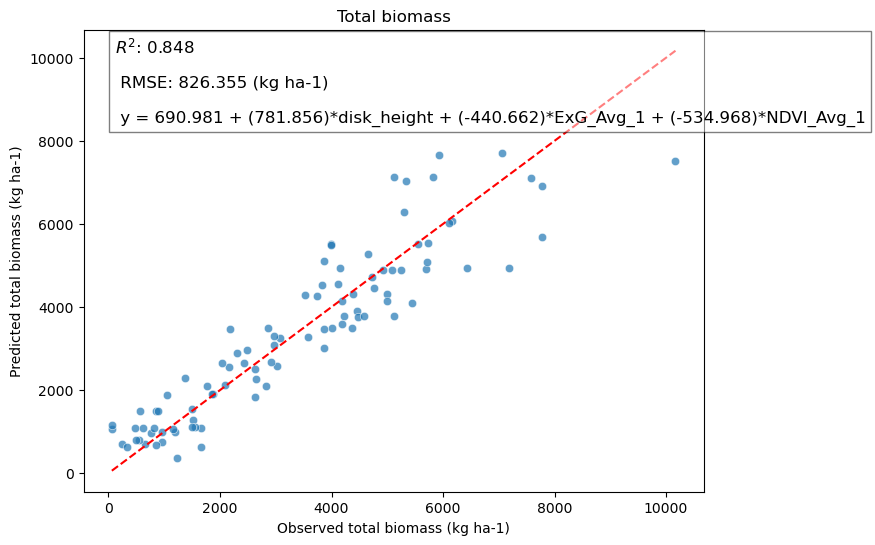

In [19]:
# Load your data
df1 = pd.read_csv("vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

target = "total_mass"  # Replace with your target column name
data[target] = data[target] * 40000
features = [col for col in data.columns if col != target][5:]
data = data[data[target] != 0].reset_index(drop=True)
feature_count = 2

# Stepwise Regression Function
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    while True:
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = OLS(y, add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                best_features.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature} with p-value {best_pval}")
        
        # Backward step
        model = OLS(y, add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Remove {worst_feature} with p-value {worst_pval}")
        
        if not changed:
            break
    return best_features

# Cross-validation and modeling
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true = []
all_preds = []
test_indices = [] 

# Store selected features across folds
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]
    
    # Stepwise regression
    selected_features = stepwise_selection(X_train, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"Fold {fold+1}, Selected Features: {selected_features}")
    
    # Train final model
    model = OLS(y_train, add_constant(X_train[selected_features])).fit()
    predictions = model.predict(add_constant(X_test[selected_features]))
    
    # Collect results
    all_true.extend(y_test)
    all_preds.extend(predictions)
    test_indices.extend(test_idx)

# Evaluate and plot
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))

# Save predictions and ground truth to a CSV
results = pd.DataFrame({
    "index": test_indices,  # Original indices from the dataset
    "Ground Truth": all_true,
    "Prediction": all_preds
})
results.sort_values(by="index", inplace=True)  # Sort by original order
results.to_csv(f"{target}_results.csv", index=False)

# Find the most frequently selected features
feature_counter = Counter([feature for features in selected_features_all_folds for feature in features])
final_features = [feature for feature, count in feature_counter.items() if count >= feature_count]  # Selected in at least 3 folds
print(f"Final Selected Features: {final_features}")

# Fit the final model on the entire dataset
X_final = data[final_features]
y_final = data[target]
final_model = OLS(y_final, add_constant(X_final)).fit()

# Display final model summary
print(final_model.summary())

# Extract the final equation
intercept = final_model.params[0]
coefficients = final_model.params[1:]
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_true, y=all_preds, alpha=0.7)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color="red", linestyle="--")
plt.title(f"Total biomass")
plt.xlabel("Observed total biomass (kg ha-1)")
plt.ylabel("Predicted total biomass (kg ha-1)")

# Annotate R2 and RMSE in the plot
plt.text(
    0.05, 0.8,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\n \n RMSE: {rmse:.3f} (kg ha-1) \n \n {equation}",
    transform=plt.gca().transAxes,  # Place in plot coordinates
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")
)

plt.show()



In [ ]:
# add multicollinarity mitigation to stepwise regression!!

# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

# ---------- Helper functions ----------
def compute_vif(X: pd.DataFrame) -> pd.DataFrame:
    """Return VIF table for columns in X."""
    X_ = X.copy()
    # Drop exact-constant cols to avoid singular matrices
    nunique = X_.nunique()
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        X_ = X_.drop(columns=const_cols)

    X_ = X_.replace([np.inf, -np.inf], np.nan).dropna(axis=0)  # keep rows with all finite
    if X_.shape[1] == 0:
        return pd.DataFrame(columns=["feature", "VIF"])
    X_const = add_constant(X_, has_constant="add")
    vifs = []
    for i, col in enumerate(X_const.columns):
        if col == "const":
            continue
        v = variance_inflation_factor(X_const.values, i)
        vifs.append({"feature": col, "VIF": v})
    return pd.DataFrame(vifs).sort_values("VIF", ascending=False).reset_index(drop=True)

def plot_corr_heatmap(X: pd.DataFrame, title: str, outfile: Path):
    if X.shape[1] < 2:
        # Nothing to plot
        return
    corr = X.corr(numeric_only=True)
    plt.figure(figsize=(min(1.2*X.shape[1], 14), min(1.2*X.shape[1], 14)))
    sns.heatmap(corr, cmap="vlag", center=0, square=True, cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

def corr_prune(X: pd.DataFrame, y: pd.Series, threshold: float = 0.9, method: str = "pearson") -> (pd.DataFrame, list):
    """
    Remove one feature from each highly correlated pair (|r| > threshold).
    Keep the feature with the stronger absolute correlation to the target.
    Returns pruned X and list of dropped features.
    """
    X_ = X.copy()
    dropped = []
    # Compute feature-target correlations
    ft_corr = X_.apply(lambda s: s.corr(y, method=method))
    # Compute feature-feature correlation matrix
    corr = X_.corr(method=method)
    # Work on upper triangle
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    while True:
        pairs = np.where(np.abs(upper.values) > threshold)
        if len(pairs[0]) == 0:
            break
        # Pick the worst pair (highest |r|)
        idx = np.argmax(np.abs(upper.values[pairs]))
        i, j = pairs[0][idx], pairs[1][idx]
        f1, f2 = upper.index[i], upper.columns[j]
        # Drop the one with weaker |corr to y|
        to_drop = f1 if abs(ft_corr[f1]) < abs(ft_corr[f2]) else f2
        X_.drop(columns=[to_drop], inplace=True)
        dropped.append(to_drop)
        # Recompute matrices restricted to remaining features
        ft_corr = X_.apply(lambda s: s.corr(y, method=method))
        corr = X_.corr(method=method)
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return X_, dropped

def vif_prune(X: pd.DataFrame, threshold: float = 10.0) -> (pd.DataFrame, list):
    """
    Iteratively drop the feature with the highest VIF above threshold.
    Returns pruned X and list of dropped features.
    """
    X_ = X.copy()
    dropped = []
    while True:
        vif_table = compute_vif(X_)
        if vif_table.empty:
            break
        max_row = vif_table.iloc[0]
        if max_row["VIF"] <= threshold or np.isinf(max_row["VIF"]) and threshold == np.inf:
            break
        feat_to_drop = max_row["feature"]
        if feat_to_drop in X_.columns:
            X_.drop(columns=[feat_to_drop], inplace=True)
            dropped.append(feat_to_drop)
        else:
            break
    return X_, dropped

def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    # Guard if X is empty
    if len(initial_features) == 0:
        return best_features

    while True:
        changed = False
        # ----- Forward -----
        remaining = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining, dtype=float)
        for new_col in remaining:
            try:
                model = OLS(y, add_constant(X[best_features + [new_col]], has_constant="add")).fit()
                if new_col in model.pvalues:
                    new_pval[new_col] = model.pvalues[new_col]
            except Exception:
                # skip ill-conditioned fits
                continue
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                best_features.append(best_feature)
                changed = True
                if verbose:
                    print(f"[Forward] Add {best_feature} (p={best_pval:.3g})")

        # If none selected yet, prevent backward step on empty set
        if len(best_features) == 0:
            if not changed:
                break
            else:
                continue

        # ----- Backward -----
        try:
            model = OLS(y, add_constant(X[best_features], has_constant="add")).fit()
            pvalues = model.pvalues.drop("const", errors="ignore")
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                best_features.remove(worst_feature)
                changed = True
                if verbose:
                    print(f"[Backward] Remove {worst_feature} (p={worst_pval:.3g})")
        except Exception as e:
            # if model fails, stop
            if verbose:
                print(f"[Backward] Stopped due to error: {e}")
            break

        if not changed:
            break
    return best_features



[Fold 1] Top pre-pruning VIFs:
          feature          VIF
0     NDRE_Avg_1  1507.239589
1     SAVI_Avg_1  1300.930494
2     NDVI_Avg_1   753.510825
3  Pixel_Count_1   713.218508
4  Pixel_Count_0   524.083756
5      ExG_Avg_1   245.023774
6     VARI_Avg_1   156.346649
7     NDVI_Avg_0   128.352058
8     SAVI_Avg_0   115.389278
9     VARI_Avg_0    29.855943
[Fold 1] Dropped by correlation (>0.9): ['Pixel_Count_1', 'SAVI_Avg_1', 'NDRE_Avg_1', 'ExG_Avg_1', 'NDVI_Avg_0', 'VARI_Avg_1', 'ExG_Avg_0', 'NDRE_Avg_0']
[Fold 1] Dropped by VIF (>10.0): ['SAVI_Avg_0']
[Fold 1] VIF after pruning (top):
          feature       VIF
0  Pixel_Count_0  2.412860
1     NDVI_Avg_1  1.984294
2     VARI_Avg_0  1.447785
3    disk_height  1.151522
[Forward] Add disk_height (p=1.71e-32)
[Forward] Add NDVI_Avg_1 (p=0.00152)
[Fold 1] Selected by stepwise: ['disk_height', 'NDVI_Avg_1']
[Fold 1] VIF after stepwise:
        feature       VIF
0  disk_height  1.003205
1   NDVI_Avg_1  1.003205

[Fold 2] Top pre-pruni

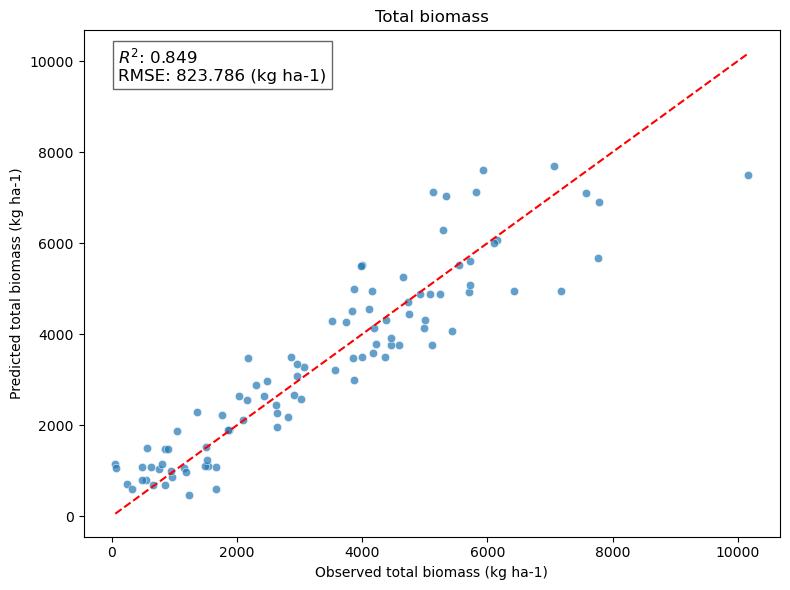

In [34]:
# Run stepwise regression for the total mass: 

# ---------- Config ----------
target = "total_mass"         # your target
# target = "grass(kg)"  # Replace with your target column name
# target = "legume(kg)"  # Replace with your target column name
feature_count = 1             # how many folds a feature must appear in to make the final model
corr_threshold = 0.90         # correlation pruning threshold (|r|)
vif_threshold = 10.0          # iterative VIF pruning threshold
plots_dir = Path(f"{target}_mc_diagnostics_plots")
plots_dir.mkdir(exist_ok=True, parents=True)

# ---------- Load & prepare data ----------
df1 = pd.read_csv("vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

data[target] = data[target] * 40000
features = [col for col in data.columns if col != target][5:]  # change accordingly!
# features = ['disk_height','Pixel_Count_0','NDVI_Avg_0','SAVI_Avg_0','VARI_Avg_0','ExG_Avg_0','NDRE_Avg_0']
# features = ['disk_height','Pixel_Count_1','NDVI_Avg_1','SAVI_Avg_1','VARI_Avg_1','ExG_Avg_1','NDRE_Avg_1']

data = data[data[target] != 0].reset_index(drop=True)

# Safety: drop non-numeric columns among features
numeric_features = [c for c in features if pd.api.types.is_numeric_dtype(data[c])]
features = numeric_features

# ---------- Cross-validation, with MC diagnostics ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true, all_preds, test_indices = [], [], []
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data), start=1):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train_raw, y_train = train_data[features].copy(), train_data[target].copy()
    X_test_raw,  y_test  = test_data[features].copy(),  test_data[target].copy()

    # Drop rows with NaN/inf in training features (keep aligned in test by columns only)
    X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
    keep_rows = X_train_raw.dropna(axis=0).index
    X_train_raw, y_train = X_train_raw.loc[keep_rows], y_train.loc[keep_rows]

    # --- Pre-diagnostic plots ---
    plot_corr_heatmap(
        X_train_raw, 
        title=f"Fold {fold}: Pre-pruning Feature Correlation",
        outfile=plots_dir / f"fold{fold}_corr_pre.png"
    )
    vif_pre = compute_vif(X_train_raw)
    vif_pre.to_csv(plots_dir / f"fold{fold}_vif_pre.csv", index=False)
    print(f"\n[Fold {fold}] Top pre-pruning VIFs:\n", vif_pre.head(10))

    # --- Reduction: correlation pruning then VIF pruning (fit on train, apply to both) ---
    X_train1, dropped_corr = corr_prune(X_train_raw, y_train, threshold=corr_threshold, method="pearson")
    print(f"[Fold {fold}] Dropped by correlation (>{corr_threshold}): {dropped_corr}")

    X_train2, dropped_vif = vif_prune(X_train1, threshold=vif_threshold)
    print(f"[Fold {fold}] Dropped by VIF (>{vif_threshold}): {dropped_vif}")

    # Align test columns to pruned training set
    kept_cols = X_train2.columns.tolist()
    X_test2 = X_test_raw[kept_cols].copy()

    # --- Post-reduction diagnostics (before stepwise) ---
    plot_corr_heatmap(
        X_train2, 
        title=f"Fold {fold}: After Corr+VIF Pruning",
        outfile=plots_dir / f"fold{fold}_corr_post_prune.png"
    )
    vif_after_prune = compute_vif(X_train2)
    vif_after_prune.to_csv(plots_dir / f"fold{fold}_vif_after_prune.csv", index=False)
    print(f"[Fold {fold}] VIF after pruning (top):\n", vif_after_prune.head(10))

    # --- Stepwise on reduced feature set ---
    selected_features = stepwise_selection(X_train2, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"[Fold {fold}] Selected by stepwise: {selected_features}")

    if len(selected_features) == 0:
        # fallback: if stepwise picks nothing, use the single strongest univariate corr feature
        if X_train2.shape[1] > 0:
            uni = X_train2.apply(lambda s: abs(s.corr(y_train))).sort_values(ascending=False)
            selected_features = [uni.index[0]]
            print(f"[Fold {fold}] Stepwise empty; fallback to {selected_features[0]}")

    # --- Post-stepwise VIF check ---
    vif_post_stepwise = compute_vif(X_train2[selected_features])
    vif_post_stepwise.to_csv(plots_dir / f"fold{fold}_vif_post_stepwise.csv", index=False)
    print(f"[Fold {fold}] VIF after stepwise:\n", vif_post_stepwise)

    # --- Fit and predict ---
    model = OLS(y_train, add_constant(X_train2[selected_features], has_constant="add")).fit()
    preds = model.predict(add_constant(X_test2[selected_features], has_constant="add"))

    # Collect
    all_true.extend(y_test)
    all_preds.extend(preds)
    test_indices.extend(test_idx)

# ---------- Evaluate & save predictions ----------
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))
results = pd.DataFrame({"index": test_indices, "Ground Truth": all_true, "Prediction": all_preds})
results.sort_values(by="index", inplace=True)
results.to_csv(f"{target}_results.csv", index=False)

# ---------- Aggregate selected features across folds ----------
feature_counter = Counter([f for sel in selected_features_all_folds for f in sel])
final_features = [feat for feat, cnt in feature_counter.items() if cnt >= feature_count]
print(f"\nFinal Selected Features (appeared in >= {feature_count} folds): {final_features}")

# ---------- Final model on full data (re-run pruning on full set for consistency) ----------
X_full_raw = data[features].copy()
y_full = data[target].copy()
X_full_raw = X_full_raw.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_full = y_full.loc[X_full_raw.index]

# ---------- initial multicollinearity diagnostics ----------
plot_corr_heatmap(X_full_raw, "Features Correlation", plots_dir / "initial_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_full_raw.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "initial_corr_table.csv", float_format="%.3f")
vif_initial = compute_vif(X_full_raw)
vif_initial.to_csv(plots_dir / "initial_vif.csv", index=False)
print("\ninitial model VIFs:\n", vif_final)

# Prune on full data (same rules)
X_full1, _ = corr_prune(X_full_raw, y_full, threshold=corr_threshold, method="pearson")
X_full2, _ = vif_prune(X_full1, threshold=vif_threshold)

# Keep only features that survived pruning AND were frequently chosen by CV
final_features = [f for f in final_features if f in X_full2.columns]
if len(final_features) == 0 and X_full2.shape[1] > 0:
    # fallback if intersection becomes empty
    uni = X_full2.apply(lambda s: abs(s.corr(y_full))).sort_values(ascending=False)
    final_features = [uni.index[0]]
    print(f"[Final] Empty intersection; fallback to {final_features[0]}")

X_final = X_full2[final_features]
final_model = OLS(y_full, add_constant(X_final, has_constant="add")).fit()
print("\n=== Final Model Summary ===")
print(final_model.summary())

# ---------- Final multicollinearity diagnostics ----------
plot_corr_heatmap(X_final, "Final Model Features Correlation", plots_dir / "final_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_final.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "final_corr_table.csv", float_format="%.3f")
vif_final = compute_vif(X_final)
vif_final.to_csv(plots_dir / "final_vif.csv", index=False)
print("\nFinal model VIFs:\n", vif_final)

# ---------- Final equation & performance plot ----------
intercept = final_model.params["const"]
coefficients = final_model.params.drop("const")
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=results["Ground Truth"], y=results["Prediction"], alpha=0.7)
mn, mx = results["Ground Truth"].min(), results["Ground Truth"].max()
plt.plot([mn, mx], [mn, mx], color="red", linestyle="--")
plt.title("Total biomass")
plt.xlabel("Observed total biomass (kg ha-1)")
plt.ylabel("Predicted total biomass (kg ha-1)")
plt.text(
    0.05, 0.9,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\nRMSE: {rmse:.3f} (kg ha-1)", #\n{equation}
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="black")
)
plt.tight_layout()
plt.savefig(f"{target}_final_obs_vs_pred.png", dpi=300)
plt.show()



[Fold 1] Top pre-pruning VIFs:
          feature        VIF
0     NDVI_Avg_0  97.697805
1     SAVI_Avg_0  93.183535
2     NDRE_Avg_0  19.072537
3     VARI_Avg_0  18.082820
4  Pixel_Count_0  17.920251
5      ExG_Avg_0  15.382065
6    disk_height   1.181707
[Fold 1] Dropped by correlation (>0.9): ['NDVI_Avg_0', 'ExG_Avg_0', 'NDRE_Avg_0']
[Fold 1] Dropped by VIF (>10.0): ['SAVI_Avg_0']
[Fold 1] VIF after pruning (top):
          feature       VIF
0     VARI_Avg_0  1.368290
1  Pixel_Count_0  1.248213
2    disk_height  1.122495
[Forward] Add disk_height (p=3.94e-28)
[Forward] Add Pixel_Count_0 (p=0.000633)
[Fold 1] Selected by stepwise: ['disk_height', 'Pixel_Count_0']
[Fold 1] VIF after stepwise:
          feature       VIF
0    disk_height  1.000045
1  Pixel_Count_0  1.000045

[Fold 2] Top pre-pruning VIFs:
          feature        VIF
0     SAVI_Avg_0  93.281115
1     NDVI_Avg_0  86.863633
2     NDRE_Avg_0  18.016483
3      ExG_Avg_0  17.465181
4     VARI_Avg_0  15.893557
5  Pixel_Count

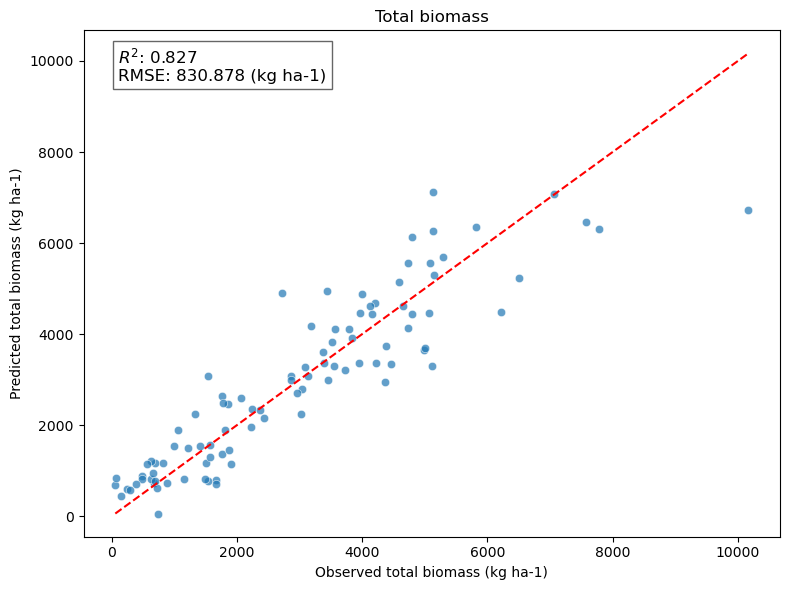

In [35]:
# Run stepwise regression for the grass mass:

# ---------- Config ----------
# target = "total_mass"         # your target
target = "grass(kg)"  # Replace with your target column name
# target = "legume(kg)"  # Replace with your target column name
feature_count = 1             # how many folds a feature must appear in to make the final model
corr_threshold = 0.90         # correlation pruning threshold (|r|)
vif_threshold = 10.0          # iterative VIF pruning threshold
plots_dir = Path(f"{target}_mc_diagnostics_plots")
plots_dir.mkdir(exist_ok=True, parents=True)

# ---------- Load & prepare data ----------
df1 = pd.read_csv("vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

data[target] = data[target] * 40000
# features = [col for col in data.columns if col != target][5:]  # change accordingly!
features = ['disk_height','Pixel_Count_0','NDVI_Avg_0','SAVI_Avg_0','VARI_Avg_0','ExG_Avg_0','NDRE_Avg_0']
# features = ['disk_height','Pixel_Count_1','NDVI_Avg_1','SAVI_Avg_1','VARI_Avg_1','ExG_Avg_1','NDRE_Avg_1']

data = data[data[target] != 0].reset_index(drop=True)

# Safety: drop non-numeric columns among features
numeric_features = [c for c in features if pd.api.types.is_numeric_dtype(data[c])]
features = numeric_features

# ---------- Cross-validation, with MC diagnostics ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true, all_preds, test_indices = [], [], []
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data), start=1):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train_raw, y_train = train_data[features].copy(), train_data[target].copy()
    X_test_raw,  y_test  = test_data[features].copy(),  test_data[target].copy()

    # Drop rows with NaN/inf in training features (keep aligned in test by columns only)
    X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
    keep_rows = X_train_raw.dropna(axis=0).index
    X_train_raw, y_train = X_train_raw.loc[keep_rows], y_train.loc[keep_rows]

    # --- Pre-diagnostic plots ---
    plot_corr_heatmap(
        X_train_raw, 
        title=f"Fold {fold}: Pre-pruning Feature Correlation",
        outfile=plots_dir / f"fold{fold}_corr_pre.png"
    )
    vif_pre = compute_vif(X_train_raw)
    vif_pre.to_csv(plots_dir / f"fold{fold}_vif_pre.csv", index=False)
    print(f"\n[Fold {fold}] Top pre-pruning VIFs:\n", vif_pre.head(10))

    # --- Reduction: correlation pruning then VIF pruning (fit on train, apply to both) ---
    X_train1, dropped_corr = corr_prune(X_train_raw, y_train, threshold=corr_threshold, method="pearson")
    print(f"[Fold {fold}] Dropped by correlation (>{corr_threshold}): {dropped_corr}")

    X_train2, dropped_vif = vif_prune(X_train1, threshold=vif_threshold)
    print(f"[Fold {fold}] Dropped by VIF (>{vif_threshold}): {dropped_vif}")

    # Align test columns to pruned training set
    kept_cols = X_train2.columns.tolist()
    X_test2 = X_test_raw[kept_cols].copy()

    # --- Post-reduction diagnostics (before stepwise) ---
    plot_corr_heatmap(
        X_train2, 
        title=f"Fold {fold}: After Corr+VIF Pruning",
        outfile=plots_dir / f"fold{fold}_corr_post_prune.png"
    )
    vif_after_prune = compute_vif(X_train2)
    vif_after_prune.to_csv(plots_dir / f"fold{fold}_vif_after_prune.csv", index=False)
    print(f"[Fold {fold}] VIF after pruning (top):\n", vif_after_prune.head(10))

    # --- Stepwise on reduced feature set ---
    selected_features = stepwise_selection(X_train2, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"[Fold {fold}] Selected by stepwise: {selected_features}")

    if len(selected_features) == 0:
        # fallback: if stepwise picks nothing, use the single strongest univariate corr feature
        if X_train2.shape[1] > 0:
            uni = X_train2.apply(lambda s: abs(s.corr(y_train))).sort_values(ascending=False)
            selected_features = [uni.index[0]]
            print(f"[Fold {fold}] Stepwise empty; fallback to {selected_features[0]}")

    # --- Post-stepwise VIF check ---
    vif_post_stepwise = compute_vif(X_train2[selected_features])
    vif_post_stepwise.to_csv(plots_dir / f"fold{fold}_vif_post_stepwise.csv", index=False)
    print(f"[Fold {fold}] VIF after stepwise:\n", vif_post_stepwise)

    # --- Fit and predict ---
    model = OLS(y_train, add_constant(X_train2[selected_features], has_constant="add")).fit()
    preds = model.predict(add_constant(X_test2[selected_features], has_constant="add"))

    # Collect
    all_true.extend(y_test)
    all_preds.extend(preds)
    test_indices.extend(test_idx)

# ---------- Evaluate & save predictions ----------
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))
results = pd.DataFrame({"index": test_indices, "Ground Truth": all_true, "Prediction": all_preds})
results.sort_values(by="index", inplace=True)
results.to_csv(f"{target}_results.csv", index=False)

# ---------- Aggregate selected features across folds ----------
feature_counter = Counter([f for sel in selected_features_all_folds for f in sel])
final_features = [feat for feat, cnt in feature_counter.items() if cnt >= feature_count]
print(f"\nFinal Selected Features (appeared in >= {feature_count} folds): {final_features}")

# ---------- Final model on full data (re-run pruning on full set for consistency) ----------
X_full_raw = data[features].copy()
y_full = data[target].copy()
X_full_raw = X_full_raw.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_full = y_full.loc[X_full_raw.index]

# ---------- initial multicollinearity diagnostics ----------
plot_corr_heatmap(X_full_raw, "Features Correlation", plots_dir / "initial_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_full_raw.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "initial_corr_table.csv", float_format="%.3f")
vif_initial = compute_vif(X_full_raw)
vif_initial.to_csv(plots_dir / "initial_vif.csv", index=False)
print("\ninitial model VIFs:\n", vif_final)

# Prune on full data (same rules)
X_full1, _ = corr_prune(X_full_raw, y_full, threshold=corr_threshold, method="pearson")
X_full2, _ = vif_prune(X_full1, threshold=vif_threshold)

# Keep only features that survived pruning AND were frequently chosen by CV
final_features = [f for f in final_features if f in X_full2.columns]
if len(final_features) == 0 and X_full2.shape[1] > 0:
    # fallback if intersection becomes empty
    uni = X_full2.apply(lambda s: abs(s.corr(y_full))).sort_values(ascending=False)
    final_features = [uni.index[0]]
    print(f"[Final] Empty intersection; fallback to {final_features[0]}")

X_final = X_full2[final_features]
final_model = OLS(y_full, add_constant(X_final, has_constant="add")).fit()
print("\n=== Final Model Summary ===")
print(final_model.summary())

# ---------- Final multicollinearity diagnostics ----------
plot_corr_heatmap(X_final, "Final Model Features Correlation", plots_dir / "final_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_final.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "final_corr_table.csv", float_format="%.3f")
vif_final = compute_vif(X_final)
vif_final.to_csv(plots_dir / "final_vif.csv", index=False)
print("\nFinal model VIFs:\n", vif_final)

# ---------- Final equation & performance plot ----------
intercept = final_model.params["const"]
coefficients = final_model.params.drop("const")
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=results["Ground Truth"], y=results["Prediction"], alpha=0.7)
mn, mx = results["Ground Truth"].min(), results["Ground Truth"].max()
plt.plot([mn, mx], [mn, mx], color="red", linestyle="--")
plt.title("Total biomass")
plt.xlabel("Observed total biomass (kg ha-1)")
plt.ylabel("Predicted total biomass (kg ha-1)")
plt.text(
    0.05, 0.9,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\nRMSE: {rmse:.3f} (kg ha-1)", #\n{equation}
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="black")
)
plt.tight_layout()
plt.savefig(f"{target}_final_obs_vs_pred.png", dpi=300)
plt.show()



[Fold 1] Top pre-pruning VIFs:
          feature          VIF
0     NDRE_Avg_1  1011.448770
1     SAVI_Avg_1   834.064464
2     NDVI_Avg_1   402.890099
3      ExG_Avg_1   126.903341
4     VARI_Avg_1   101.948120
5  Pixel_Count_1     2.559990
6    disk_height     1.518202
[Fold 1] Dropped by correlation (>0.9): ['NDVI_Avg_1', 'SAVI_Avg_1', 'ExG_Avg_1', 'NDRE_Avg_1']
[Fold 1] Dropped by VIF (>10.0): []
[Fold 1] VIF after pruning (top):
          feature       VIF
0     VARI_Avg_1  1.981356
1  Pixel_Count_1  1.945037
2    disk_height  1.027178
[Forward] Add disk_height (p=6.38e-07)
[Fold 1] Selected by stepwise: ['disk_height']
[Fold 1] VIF after stepwise:
        feature  VIF
0  disk_height  1.0

[Fold 2] Top pre-pruning VIFs:
          feature          VIF
0     SAVI_Avg_1  1100.638443
1     NDRE_Avg_1  1038.487437
2     NDVI_Avg_1   562.424177
3      ExG_Avg_1   139.789055
4     VARI_Avg_1    97.039363
5  Pixel_Count_1     2.663762
6    disk_height     1.445423
[Fold 2] Dropped by cor

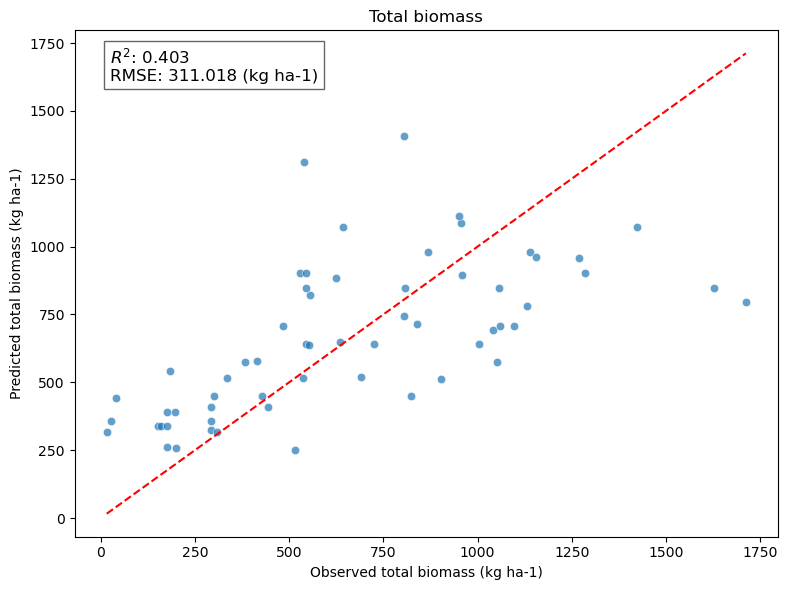

In [36]:
# Run stepwise regression for the legume mass:

# ---------- Config ----------
# target = "total_mass"         # your target
# target = "grass(kg)"  # Replace with your target column name
target = "legume(kg)"  # Replace with your target column name
feature_count = 1             # how many folds a feature must appear in to make the final model
corr_threshold = 0.90         # correlation pruning threshold (|r|)
vif_threshold = 10.0          # iterative VIF pruning threshold
plots_dir = Path(f"{target}_mc_diagnostics_plots")
plots_dir.mkdir(exist_ok=True, parents=True)

# ---------- Load & prepare data ----------
df1 = pd.read_csv("vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

data[target] = data[target] * 40000
# features = [col for col in data.columns if col != target][5:]  # change accordingly!
# features = ['disk_height','Pixel_Count_0','NDVI_Avg_0','SAVI_Avg_0','VARI_Avg_0','ExG_Avg_0','NDRE_Avg_0']
features = ['disk_height','Pixel_Count_1','NDVI_Avg_1','SAVI_Avg_1','VARI_Avg_1','ExG_Avg_1','NDRE_Avg_1']

data = data[data[target] != 0].reset_index(drop=True)

# Safety: drop non-numeric columns among features
numeric_features = [c for c in features if pd.api.types.is_numeric_dtype(data[c])]
features = numeric_features

# ---------- Cross-validation, with MC diagnostics ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true, all_preds, test_indices = [], [], []
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data), start=1):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train_raw, y_train = train_data[features].copy(), train_data[target].copy()
    X_test_raw,  y_test  = test_data[features].copy(),  test_data[target].copy()

    # Drop rows with NaN/inf in training features (keep aligned in test by columns only)
    X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
    keep_rows = X_train_raw.dropna(axis=0).index
    X_train_raw, y_train = X_train_raw.loc[keep_rows], y_train.loc[keep_rows]

    # --- Pre-diagnostic plots ---
    plot_corr_heatmap(
        X_train_raw, 
        title=f"Fold {fold}: Pre-pruning Feature Correlation",
        outfile=plots_dir / f"fold{fold}_corr_pre.png"
    )
    vif_pre = compute_vif(X_train_raw)
    vif_pre.to_csv(plots_dir / f"fold{fold}_vif_pre.csv", index=False)
    print(f"\n[Fold {fold}] Top pre-pruning VIFs:\n", vif_pre.head(10))

    # --- Reduction: correlation pruning then VIF pruning (fit on train, apply to both) ---
    X_train1, dropped_corr = corr_prune(X_train_raw, y_train, threshold=corr_threshold, method="pearson")
    print(f"[Fold {fold}] Dropped by correlation (>{corr_threshold}): {dropped_corr}")

    X_train2, dropped_vif = vif_prune(X_train1, threshold=vif_threshold)
    print(f"[Fold {fold}] Dropped by VIF (>{vif_threshold}): {dropped_vif}")

    # Align test columns to pruned training set
    kept_cols = X_train2.columns.tolist()
    X_test2 = X_test_raw[kept_cols].copy()

    # --- Post-reduction diagnostics (before stepwise) ---
    plot_corr_heatmap(
        X_train2, 
        title=f"Fold {fold}: After Corr+VIF Pruning",
        outfile=plots_dir / f"fold{fold}_corr_post_prune.png"
    )
    vif_after_prune = compute_vif(X_train2)
    vif_after_prune.to_csv(plots_dir / f"fold{fold}_vif_after_prune.csv", index=False)
    print(f"[Fold {fold}] VIF after pruning (top):\n", vif_after_prune.head(10))

    # --- Stepwise on reduced feature set ---
    selected_features = stepwise_selection(X_train2, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"[Fold {fold}] Selected by stepwise: {selected_features}")

    if len(selected_features) == 0:
        # fallback: if stepwise picks nothing, use the single strongest univariate corr feature
        if X_train2.shape[1] > 0:
            uni = X_train2.apply(lambda s: abs(s.corr(y_train))).sort_values(ascending=False)
            selected_features = [uni.index[0]]
            print(f"[Fold {fold}] Stepwise empty; fallback to {selected_features[0]}")

    # --- Post-stepwise VIF check ---
    vif_post_stepwise = compute_vif(X_train2[selected_features])
    vif_post_stepwise.to_csv(plots_dir / f"fold{fold}_vif_post_stepwise.csv", index=False)
    print(f"[Fold {fold}] VIF after stepwise:\n", vif_post_stepwise)

    # --- Fit and predict ---
    model = OLS(y_train, add_constant(X_train2[selected_features], has_constant="add")).fit()
    preds = model.predict(add_constant(X_test2[selected_features], has_constant="add"))

    # Collect
    all_true.extend(y_test)
    all_preds.extend(preds)
    test_indices.extend(test_idx)

# ---------- Evaluate & save predictions ----------
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))
results = pd.DataFrame({"index": test_indices, "Ground Truth": all_true, "Prediction": all_preds})
results.sort_values(by="index", inplace=True)
results.to_csv(f"{target}_results.csv", index=False)

# ---------- Aggregate selected features across folds ----------
feature_counter = Counter([f for sel in selected_features_all_folds for f in sel])
final_features = [feat for feat, cnt in feature_counter.items() if cnt >= feature_count]
print(f"\nFinal Selected Features (appeared in >= {feature_count} folds): {final_features}")

# ---------- Final model on full data (re-run pruning on full set for consistency) ----------
X_full_raw = data[features].copy()
y_full = data[target].copy()
X_full_raw = X_full_raw.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_full = y_full.loc[X_full_raw.index]

# ---------- initial multicollinearity diagnostics ----------
plot_corr_heatmap(X_full_raw, "Features Correlation", plots_dir / "initial_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_full_raw.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "initial_corr_table.csv", float_format="%.3f")
vif_initial = compute_vif(X_full_raw)
vif_initial.to_csv(plots_dir / "initial_vif.csv", index=False)
print("\ninitial model VIFs:\n", vif_final)

# Prune on full data (same rules)
X_full1, _ = corr_prune(X_full_raw, y_full, threshold=corr_threshold, method="pearson")
X_full2, _ = vif_prune(X_full1, threshold=vif_threshold)

# Keep only features that survived pruning AND were frequently chosen by CV
final_features = [f for f in final_features if f in X_full2.columns]
if len(final_features) == 0 and X_full2.shape[1] > 0:
    # fallback if intersection becomes empty
    uni = X_full2.apply(lambda s: abs(s.corr(y_full))).sort_values(ascending=False)
    final_features = [uni.index[0]]
    print(f"[Final] Empty intersection; fallback to {final_features[0]}")

X_final = X_full2[final_features]
final_model = OLS(y_full, add_constant(X_final, has_constant="add")).fit()
print("\n=== Final Model Summary ===")
print(final_model.summary())

# ---------- Final multicollinearity diagnostics ----------
plot_corr_heatmap(X_final, "Final Model Features Correlation", plots_dir / "final_corr.png")
# Save correlation matrix as CSV
corr_matrix = X_final.corr(numeric_only=True)
corr_matrix.to_csv(plots_dir / "final_corr_table.csv", float_format="%.3f")
vif_final = compute_vif(X_final)
vif_final.to_csv(plots_dir / "final_vif.csv", index=False)
print("\nFinal model VIFs:\n", vif_final)

# ---------- Final equation & performance plot ----------
intercept = final_model.params["const"]
coefficients = final_model.params.drop("const")
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=results["Ground Truth"], y=results["Prediction"], alpha=0.7)
mn, mx = results["Ground Truth"].min(), results["Ground Truth"].max()
plt.plot([mn, mx], [mn, mx], color="red", linestyle="--")
plt.title("Total biomass")
plt.xlabel("Observed total biomass (kg ha-1)")
plt.ylabel("Predicted total biomass (kg ha-1)")
plt.text(
    0.05, 0.9,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\nRMSE: {rmse:.3f} (kg ha-1)", #\n{equation}
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="black")
)
plt.tight_layout()
plt.savefig(f"{target}_final_obs_vs_pred.png", dpi=300)
plt.show()
